In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import shap

In [2]:
sellers = pd.read_csv('data/sellers_dataset.csv', parse_dates=['first_contact_date', 'won_date'])
sellers.head()

,mql_id,first_contact_date,landing_page_id,origin,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,seller_zip_code_prefix,seller_city,seller_state
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,30421.0,belo horizonte,MG


In [12]:
len(sellers)

8000

In [14]:
sellers['mql_id'].nunique()

8000

In [30]:
# Extract year and month from 'contact_date'
sellers['contact_year'] = sellers['first_contact_date'].dt.year
sellers['contact_month'] = sellers['first_contact_date'].dt.month

# Calculate the total number of sales per year and month
total_sales = sellers.groupby(['contact_year', 'contact_month']).size().reset_index(name='total_sales')

# Calculate the number of closed sales per year and month
closed_sales = sellers.dropna(subset=['seller_id']).groupby(['contact_year', 'contact_month']).size().reset_index(name='closed_sales')

# Merge total_sales and closed_sales DataFrames
sales_data = pd.merge(total_sales, closed_sales, on=['contact_year', 'contact_month'], how='left')

# Calculate the percentage of closed sales per year and month
sales_data['percentage_closed_sales'] = (sales_data['closed_sales'] / sales_data['total_sales']) * 100

sales_data = sales_data.fillna(value=0)

In [31]:
sales_data

,contact_year,contact_month,total_sales,closed_sales,percentage_closed_sales
0,2017,6,4,0.0,0.000000
1,2017,7,239,2.0,0.836820
2,2017,8,386,9.0,2.331606
3,2017,9,312,7.0,2.243590
4,2017,10,416,14.0,3.365385
5,2017,11,445,18.0,4.044944
6,2017,12,200,11.0,5.500000
7,2018,1,1141,152.0,13.321648
8,2018,2,1028,149.0,14.494163
9,2018,3,1174,167.0,14.224872


In [25]:
# Calculate the total number of deals per origin
total_deals = sellers.groupby('origin').size().reset_index(name='total_deals')

# Calculate the number of closed deals per origin
closed_deals = sellers.dropna(subset=['seller_id']).groupby('origin').size().reset_index(name='closed_deals')

# Merge total_deals and closed_deals DataFrames
deal_data = pd.merge(total_deals, closed_deals, on='origin', how='left')

# Calculate the percentages of closed deals per origin
deal_data['percentage_closed'] = (deal_data['closed_deals'] / deal_data['total_deals']) * 100

deal_data = deal_data.sort_values(by='percentage_closed', ascending=False)

In [26]:
deal_data

,origin,total_deals,closed_deals,percentage_closed
9,unknown,1099,179,16.287534
6,paid_search,1586,195,12.295082
3,organic_search,2296,271,11.803136
0,direct_traffic,499,56,11.222445
7,referral,284,24,8.450704
8,social,1350,75,5.555556
1,display,118,6,5.084746
5,other_publicities,65,3,4.615385
2,email,493,15,3.042596
4,other,150,4,2.666667


In [87]:
closed_deals = sellers.dropna(subset=['seller_id'], axis=0)
closed_deals

,mql_id,first_contact_date,landing_page_id,origin,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,...,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,seller_zip_code_prefix,seller_city,seller_state,contact_year,contact_month
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,...,NaN,NaN,reseller,NaN,0.0,30421.0,belo horizonte,MG,2018,2
12,a555fb36b9368110ede0f043dfc3b9a0,2018-04-04,2f08471dfb83baef522f952438a36f6e,referral,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,...,NaN,NaN,reseller,NaN,0.0,NaN,NaN,NaN,2018,4
14,327174d3648a2d047e8940d7d15204ca,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,...,NaN,NaN,reseller,NaN,0.0,93542.0,novo hamburgo,RS,2018,4
39,f5fee8f7da74f4887f5bcae2bafb6dd6,2018-01-14,22c29808c4f815213303f8933030604c,paid_search,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,...,NaN,NaN,reseller,NaN,0.0,NaN,NaN,NaN,2018,1
67,ffe640179b554e295c167a2f6be528e0,2017-10-09,a0fbc0263cb98bdb0d72b9f9f283a172,unknown,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,...,NaN,NaN,manufacturer,NaN,0.0,11015.0,santos,SP,2017,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7978,df9a2abe2ad3f2d8758b675ac8331ecf,2018-03-28,a7982125ff7aa3b2054c6e44f9d28522,organic_search,bfcc27719640628da877db48b672b169,45749fb708130f78d0db07d8d80f030b,a8387c01a09e99ce014107505b92388c,2018-08-01 20:22:31,home_decor,offline,...,NaN,NaN,reseller,NaN,0.0,NaN,NaN,NaN,2018,3
7983,8723201570415eb23b4f095d8c20a27c,2018-05-18,b76ef37428e6799c421989521c0e5077,organic_search,4a82eab98441aeb64566e2776c1fb2b6,370c9f455f93a9a96cbe9bea48e70033,4b339f9567d060bcea4f5136b9f5949e,2018-09-27 18:58:41,construction_tools_house_garden,online_big,...,NaN,NaN,reseller,132.0,200000.0,NaN,NaN,NaN,2018,5
7991,2e57665b8faf05c967a801eb5aedfa0a,2018-05-25,40dec9f3d5259a3d2dbcdab2114fae47,paid_search,55031883943971ca22db6894574cfe2c,370c9f455f93a9a96cbe9bea48e70033,a8387c01a09e99ce014107505b92388c,2018-06-06 20:15:26,computers,online_medium,...,NaN,NaN,reseller,NaN,0.0,NaN,NaN,NaN,2018,5
7994,40955be51cc85c5a5a6cdd12b19e9f10,2018-02-04,88740e65d5d6b056e0cda098e1ea6313,social,c0e933c238e41f0cd459d6025ee9b364,068066e24f0c643eb1d089c7dd20cd73,d3d1e91a157ea7f90548eef82f1955e3,2018-03-06 15:52:23,pet,online_beginner,...,NaN,NaN,reseller,NaN,0.0,NaN,NaN,NaN,2018,2


In [9]:

# Calculate the time difference in days
closed_deals['time_difference'] = (closed_deals['won_date'] - closed_deals['first_contact_date']).dt.days

# Calculate the average time difference in days
average_time_difference = closed_deals['time_difference'].mean()

print(average_time_difference)

48.44061757719715


C:\Users\User\AppData\Local\Temp\ipykernel_18760\1341012561.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_deals['time_difference'] = (closed_deals['won_date'] - closed_deals['first_contact_date']).dt.days


In [8]:
closed_deals

,mql_id,first_contact_date,landing_page_id,origin,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,...,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,seller_zip_code_prefix,seller_city,seller_state,time_difference
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,...,NaN,NaN,NaN,reseller,NaN,0.0,30421.0,belo horizonte,MG,5
12,a555fb36b9368110ede0f043dfc3b9a0,2018-04-04,2f08471dfb83baef522f952438a36f6e,referral,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,...,NaN,NaN,NaN,reseller,NaN,0.0,NaN,NaN,NaN,34
14,327174d3648a2d047e8940d7d15204ca,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,...,NaN,NaN,NaN,reseller,NaN,0.0,93542.0,novo hamburgo,RS,63
39,f5fee8f7da74f4887f5bcae2bafb6dd6,2018-01-14,22c29808c4f815213303f8933030604c,paid_search,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,...,NaN,NaN,NaN,reseller,NaN,0.0,NaN,NaN,NaN,3
67,ffe640179b554e295c167a2f6be528e0,2017-10-09,a0fbc0263cb98bdb0d72b9f9f283a172,unknown,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,...,NaN,NaN,NaN,manufacturer,NaN,0.0,11015.0,santos,SP,267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7978,df9a2abe2ad3f2d8758b675ac8331ecf,2018-03-28,a7982125ff7aa3b2054c6e44f9d28522,organic_search,bfcc27719640628da877db48b672b169,45749fb708130f78d0db07d8d80f030b,a8387c01a09e99ce014107505b92388c,2018-08-01 20:22:31,home_decor,offline,...,NaN,NaN,NaN,reseller,NaN,0.0,NaN,NaN,NaN,126
7983,8723201570415eb23b4f095d8c20a27c,2018-05-18,b76ef37428e6799c421989521c0e5077,organic_search,4a82eab98441aeb64566e2776c1fb2b6,370c9f455f93a9a96cbe9bea48e70033,4b339f9567d060bcea4f5136b9f5949e,2018-09-27 18:58:41,construction_tools_house_garden,online_big,...,NaN,NaN,NaN,reseller,132.0,200000.0,NaN,NaN,NaN,132
7991,2e57665b8faf05c967a801eb5aedfa0a,2018-05-25,40dec9f3d5259a3d2dbcdab2114fae47,paid_search,55031883943971ca22db6894574cfe2c,370c9f455f93a9a96cbe9bea48e70033,a8387c01a09e99ce014107505b92388c,2018-06-06 20:15:26,computers,online_medium,...,NaN,NaN,NaN,reseller,NaN,0.0,NaN,NaN,NaN,12
7994,40955be51cc85c5a5a6cdd12b19e9f10,2018-02-04,88740e65d5d6b056e0cda098e1ea6313,social,c0e933c238e41f0cd459d6025ee9b364,068066e24f0c643eb1d089c7dd20cd73,d3d1e91a157ea7f90548eef82f1955e3,2018-03-06 15:52:23,pet,online_beginner,...,NaN,NaN,NaN,reseller,NaN,0.0,NaN,NaN,NaN,30


In [8]:
sellers['first_contact_date'].max()

Timestamp('2018-05-31 00:00:00')

In [97]:
model_df = closed_deals[['origin', 'business_segment', 'business_type', 'declared_monthly_revenue']]
model_df = model_df.dropna(axis=0)
model_df.head()

,origin,business_segment,business_type,declared_monthly_revenue
4,organic_search,pet,reseller,0.0
12,referral,car_accessories,reseller,0.0
14,organic_search,home_appliances,reseller,0.0
39,paid_search,food_drink,reseller,0.0
67,unknown,home_appliances,manufacturer,0.0


In [98]:
model_df.isna().sum()

origin                      0
business_segment            0
business_type               0
declared_monthly_revenue    0
dtype: int64

In [99]:
model_df.shape

(817, 4)

In [100]:
model_df_encoded = pd.get_dummies(model_df.drop('declared_monthly_revenue', axis=1))
model_df_encoded.head()

,origin_direct_traffic,origin_display,origin_email,origin_organic_search,origin_other,origin_other_publicities,origin_paid_search,origin_referral,origin_social,origin_unknown,...,business_segment_phone_mobile,business_segment_religious,business_segment_small_appliances,business_segment_sports_leisure,business_segment_stationery,business_segment_toys,business_segment_watches,business_type_manufacturer,business_type_other,business_type_reseller
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
14,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
67,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [101]:
X_train, X_test, y_train, y_test = train_test_split(model_df_encoded, model_df['declared_monthly_revenue'], test_size=0.2, random_state=42)

In [102]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [103]:
explainer = shap.Explainer(dt)
shap_values = explainer(X_test)

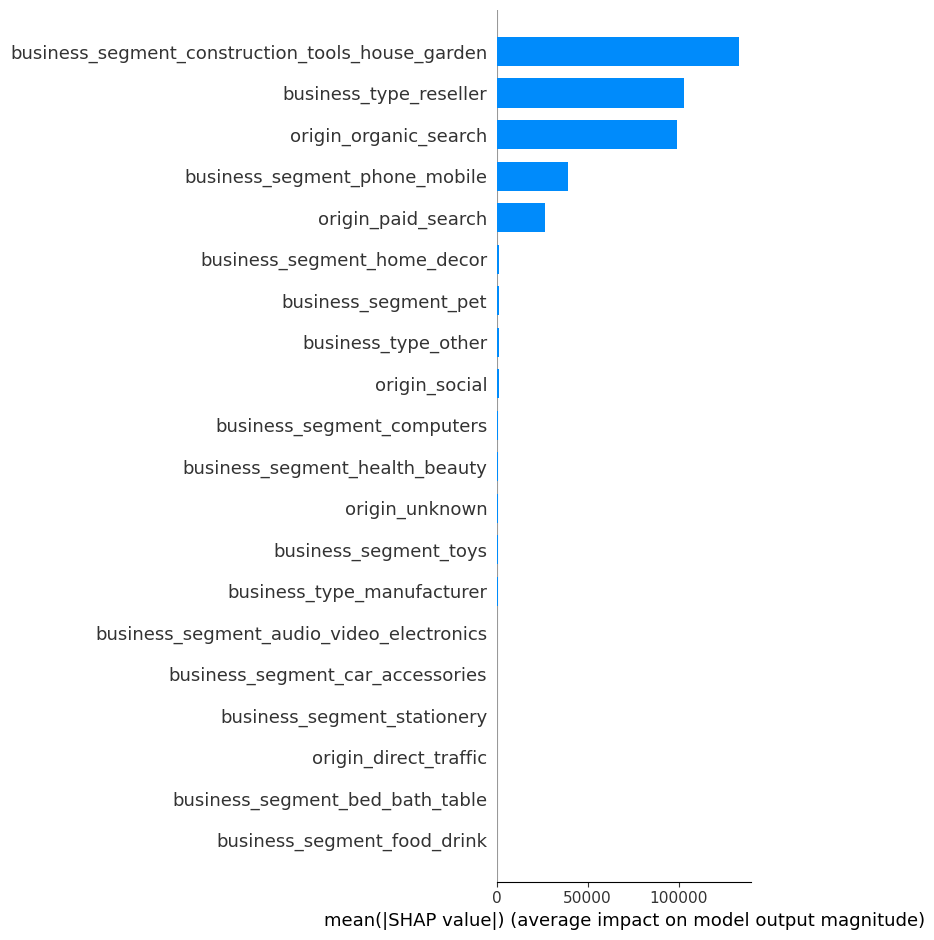

In [104]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [105]:
vals= np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head()

,col_name,feature_importance_vals
18,business_segment_construction_tools_house_garden,133466.211077
45,business_type_reseller,103303.329402
3,origin_organic_search,99199.036886
36,business_segment_phone_mobile,39102.330357
6,origin_paid_search,26718.305047


## Forecast sales 

In [32]:
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [42]:
endog = sales_data['closed_sales']

best_lags = ar_select_order(endog, maxlag=5).ar_lags
best_lags

[1, 2, 3, 4, 5]

In [59]:
p = best_lags[-1]
model = SARIMAX(endog, order=(p,0,0))
res = model.fit(disp=False)
preds = res.get_forecast(6)

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.


In [61]:
conf_int_df = preds.conf_int()
conf_int_df

,lower closed_sales,upper closed_sales
12,37.768293,198.237252
13,-18.793490,197.278900
14,-75.783268,193.274073
15,-108.354400,209.596384
16,-136.526895,201.808301
17,-152.620163,201.934574


In [60]:
preds.predicted_mean

12    118.002772
13     89.242705
14     58.745403
15     50.620992
16     32.640703
17     24.657205
Name: predicted_mean, dtype: float64

In [65]:
preds_df = conf_int_df.merge(preds.predicted_mean.to_frame(), left_index=True, right_index=True)
preds_df

,lower closed_sales,upper closed_sales,predicted_mean
12,37.768293,198.237252,118.002772
13,-18.793490,197.278900,89.242705
14,-75.783268,193.274073,58.745403
15,-108.354400,209.596384,50.620992
16,-136.526895,201.808301,32.640703
17,-152.620163,201.934574,24.657205


In [66]:
preds_df = preds_df.applymap(round)
preds_df = preds_df.applymap(lambda x: int(x))

In [68]:
preds_df = preds_df.applymap(lambda x: 0 if x < 0 else x)
preds_df

,lower closed_sales,upper closed_sales,predicted_mean
12,38,198,118
13,0,197,89
14,0,193,59
15,0,210,51
16,0,202,33
17,0,202,25


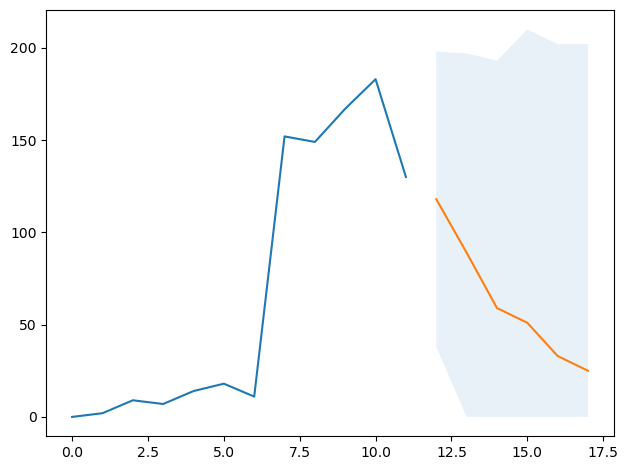

In [76]:
fig, ax = plt.subplots()

ax.plot(sales_data['closed_sales'])
ax.plot(preds_df['predicted_mean'])
ax.fill_between(preds_df.index, preds_df['lower closed_sales'], preds_df['upper closed_sales'], alpha=0.1)

plt.tight_layout()

In [107]:
start_date = pd.to_datetime('2017-06-01')

# Create a range of 18 monthly dates
monthly_dates = pd.date_range(start=start_date, periods=18, freq='M')

# Print the monthly dates
print(monthly_dates)

[Timestamp('2017-06-30 00:00:00', freq='M'), Timestamp('2017-07-31 00:00:00', freq='M'), Timestamp('2017-08-31 00:00:00', freq='M'), Timestamp('2017-09-30 00:00:00', freq='M'), Timestamp('2017-10-31 00:00:00', freq='M'), Timestamp('2017-11-30 00:00:00', freq='M'), Timestamp('2017-12-31 00:00:00', freq='M'), Timestamp('2018-01-31 00:00:00', freq='M'), Timestamp('2018-02-28 00:00:00', freq='M'), Timestamp('2018-03-31 00:00:00', freq='M'), Timestamp('2018-04-30 00:00:00', freq='M'), Timestamp('2018-05-31 00:00:00', freq='M'), Timestamp('2018-06-30 00:00:00', freq='M'), Timestamp('2018-07-31 00:00:00', freq='M'), Timestamp('2018-08-31 00:00:00', freq='M'), Timestamp('2018-09-30 00:00:00', freq='M'), Timestamp('2018-10-31 00:00:00', freq='M'), Timestamp('2018-11-30 00:00:00', freq='M')]
